# Analysis:  The Banana Project
---
## What does the Banana Learning Data look like, and what does it tell us?

In this notebook I visualize and compare the Learning Data generated during training, [Navigation Notebook](Navigation.ipynb), and hopefully get some insight that will help with next steps

## Initialize notbook setings

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Load Learning Data
- training_log
- best_agent

In [3]:
target_score = 13

In [4]:
# Trained agents
training_log = []
agents = ['dqn_agent_1_2', 'dqn_agent_1_2_3', 'dqn_agent_1_3_4_005', 
          'dqn_agent_1_3_4_01', 'dqn_agent_1_3_4_02']

In [5]:
dir_path = os.path.abspath("learning_data")

In [6]:
for agent in agents:
  file_name = "{}_learning_data.csv".format(agent)
  file_path = os.path.join(dir_path, file_name)
  
  d = pd.read_csv(file_path)
  d['agent'] = agent
  training_log.append(d) 
  
  
len(training_log)

5

In [7]:
training_data = pd.concat(training_log, ignore_index = True)
training_data.shape

(13872, 6)

In [8]:
file_name = "best_agent_learning_session_data.csv"
file_path = os.path.join(dir_path, file_name)

best_agent = pd.read_csv(file_path)
best_agent = best_agent.rename({'index': 'agent'}, axis = 1)
best_agent.shape

(5, 4)

### Data Preparation

In [9]:
# Viz colors fot the agent to be assigned by learning speed 
# in terms of average number of episodes

colors = {
  0: 'DarkOrange', 
  1: 'CadetBlue', 
  2: 'SaddleBrown', 
  3: 'LightGray', 
  4: 'LightGray'
}

In [10]:
agent_learning_speed = (training_data
                        .groupby(['agent', 'session'])['episode']
                        .count()
                        .groupby(level = 0)
                        # .mean()
                        .agg(['min', 'mean', 'max'])
                        .rename({'min': 'fastest_session', 
                                 'mean': 'avg_episodes', 
                                 'max': 'slowest'}, axis = 1)
                        .sort_values(['avg_episodes'])
                        .reset_index()
                       )
  
agent_learning_speed.loc[:, 'color'] = list(colors.values())

agent_learning_speed.shape

(5, 5)

In [11]:
# label the best agents with the corresponding viz color

best_agent = pd.merge(best_agent, agent_learning_speed[['agent', 'color']], 
                      how = 'left', on = ['agent'], sort = False
                     )
best_agent.shape

(5, 5)

### Viz functions

In [12]:

def plot_top_3():
  """
  Bar plot of the agents learning speed as avg.episodes to reach the target Score
  """
  # plot the training avg n_episodes

  fig = plt.figure(figsize=(15, 7))
  ax = fig.add_subplot(111)

  bars = ax.bar(x = agent_learning_speed['agent'], 
                height = agent_learning_speed['avg_episodes'], 
                color = agent_learning_speed['color'], 
                width = 0.6, edgecolor = 'LightGray')

  for i in range(agent_learning_speed.shape[0]):
    y = agent_learning_speed.iloc[i]['avg_episodes']
    ax.text(x = i - 0.1, y = y + 10, s = '{}'.format(y), color = 'gray', 
            fontdict = {'fontsize': 12}
           )

  ax.set_ylabel('Average number of episodes')
  ax.set_xlabel('Agents')

  title = "Agent Learning Average Number of Episodes to Tartge Score\n(n_episodes / n_sessions)\n"
  ax.set_title(title)
  plt.show()
  
  return

In [13]:

def plot_agent_learning(agents):
  """
  Plots the learning progress of each agent in agents
  """
  
  # plot the learning data
  
  fig, ax = plt.subplots(5, 1, sharey = False, figsize = (15, 30))  
  fig.subplots_adjust(hspace = 0.6)
  
  for i, agent in enumerate(agents):
    
    # get the best session for the agent
    best_agent_info = best_agent[best_agent['agent'] == agent]
    data = training_data[((training_data['agent'] == agent) 
                          & (training_data['session'] == best_agent_info['session'].values[0])
                         )]
    
    # plot the score per episode
    ax[i].plot(data['episode'], data['score'], color = 'LightGray', 
                  label = 'episode score')
    # plot the learning progress as the mean of 100 consecutive episodes
    if best_agent_info['color'].values[0] == 'LightGray':
      color = 'black'
    else:
      color = best_agent_info['color'].values[0]
    ax[i].plot(data['episode'], data['score'].rolling(window = 100).mean(), 
               # color = 'DarkOrange', 
               color = color, 
               label = '100 consecutive episodes mean score'
              )
    # plot the target score
    ax[i].hlines(y = target_score, xmin = 0, xmax = data['episode'].max(), color = 'Gray', 
              linewidths = 0.5)
    # the best score in the last 100 episodes
    ax[i].vlines(x = best_agent_info['episode'], ymin = 0, 
                 ymax = best_agent_info['score'], color = 'LightGray')
    
    txt = "{:.2f}\nbest score".format(best_agent_info['score'].values[0])
    ax[i].text(x = best_agent_info['episode'] + 1, y = 0, s = txt, color = 'Gray')
    ax[i].scatter(x = best_agent_info['episode'], y = best_agent_info['score'], 
                  color = color)
    
    
    
    ax[i].set_ylabel('Score')
    ax[i].set_xlabel('Episode #')
    ax[i].legend()
    
    
    ax[i].set_title("{} Agent Learning Performance:\nEpisode vs. Score\n".format(agent))
  plt.show()

  return
  

In [14]:

def plot_learning_rate(agents):
  """
  Plots agents' learning rate as the average of mean scores over 50 consecutive 100 episodes
  """
  
  # plot agents best session learning rate

  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111)

  for agent in agents:
    # agents = list(training_log.keys())

    # get the best session for the agent
    best_agent_info = best_agent[best_agent['agent'] == agent]
    data = training_data[((training_data['agent'] == agent) 
                          & (training_data['session'] == best_agent_info['session'].values[0])
                         )]

    # the mean score over 100 consecutive episodes
    mean_data = data['score'].rolling(window = 100).mean()[100:]

    # the average learning rate over ro consecutive mean scores
    learnig_rte = ((mean_data - mean_data.shift(1)) / mean_data).rolling(window = 50).mean()
    
    ax.plot(data['episode'][100:], learnig_rte, 
            color = best_agent_info['color'].values[0], 
            label = agent)
    ax.scatter(x = data['episode'][-1:], y = learnig_rte.iloc[-1:], 
               color = best_agent_info['color'].values[0])

    if not best_agent_info['color'].values[0] == 'LightGray':
      ax.text(x = data['episode'][-1:], y = learnig_rte.iloc[-1:] + 0.0005, 
              s = "{:.4f}".format(learnig_rte.iloc[-1:].values[0]), 
              color = best_agent_info['color'].values[0]
             )

  ax.set_ylabel('learning rate')
  ax.set_xlabel('Episode')
  ax.legend()

  title = "Agent Learning Rate Decay\nOf each Agent's best learning session\n"
  ax.set_title(title)

  plt.show()
  
  return

### Analysis
---
Learning strategy implementation list:
1. Fixed Q-Targets
2. Experience Replay
3. Double Q-Learning
4. Prioritized Experience Replay

Agent's name includes the number of the strategies implemented:
- **dqn_agent_1_2**: Implements Fixed Q-Targets and Experience Replay
- **dqn_agent_1_2_3**: Implements Fixed Q-Targets, Experience Replay, and Double Q-Learning
- **dqn_agent_1_3_4**: Implements Fixed Q-Targets, Prioritized Experience Replay, and Double Q-learning

#### Learning Speed

> Learning speed is defined as the average number of eposides an agent implementaiton takes to reach the target score

Fixed Q-Targets, Experience Replay, and Double Q-Learning yeild the fastest learning performance in terms of average number of episodes the agent took to reach the target score over **5** learning sessions

The addition of a _Double Q-Learning_ strategy makes a difference on the speed of learning, compared to the agent that implementes Fixed Q-Targets and Experience Replay alone.

The _Prioritized Experience Replay_ strategy comes out short in this example.  It looks like in this environment more learning is done from the more common experience than from the least common ones.  For instance, traversing the open space (_most common experience_), yealds more learning opportunity ovrer facing the wall (_lest common experience_)

On the other hand `speed ≠ quality`.  It could be that the _Prioritized Experience Replay_ agent takes longer to learn the environment, but the learned model is better at solving the environment.

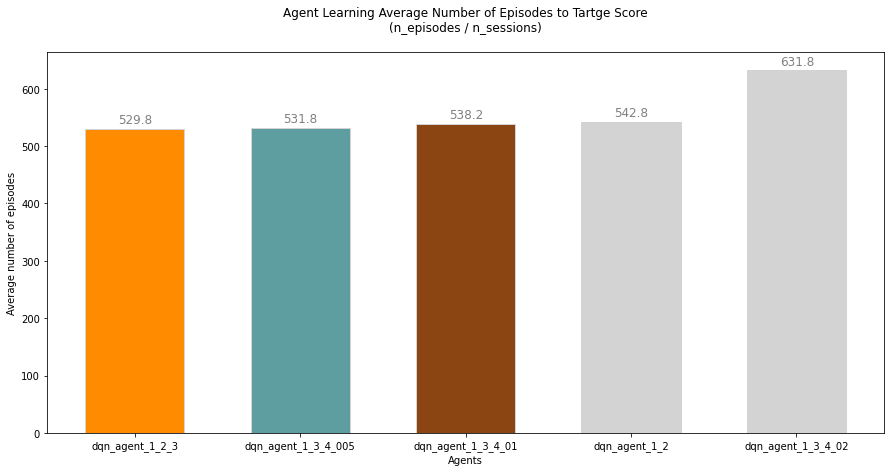

In [15]:
plot_top_3()

In [16]:
agent_learning_speed

,agent,fastest_session,avg_episodes,slowest,color
0,dqn_agent_1_2_3,482,529.8,563,DarkOrange
1,dqn_agent_1_3_4_005,484,531.8,559,CadetBlue
2,dqn_agent_1_3_4_01,508,538.2,601,SaddleBrown
3,dqn_agent_1_2,496,542.8,655,LightGray
4,dqn_agent_1_3_4_02,566,631.8,683,LightGray


#### Agent's Learning Process
The learning session plot shows how the agent performance improves as it interacts with the environment over time

Agents learn by interacting with the environment for as many episodes as are necessary to achieve the target goal of +13 mean-score over 100 consecutive episodes, and each episode is made out of 1000 experiences

The learning plot shows learning progress by episode, and as the mean of 100 consecutive episodes.

For the plot I selected, for each agent, the session with the highest score.  

The highest score, among the best scoring sessions, is **23.00**, and we can see that the agent that implements _Prioritized Experience Replay_ with a 10% experience replay $\alpha$ reaches this score faster than the other agents, and that its training signal shows less volatility, compared to the other two faster learning agents

> It seems that _Prioritized Experience Replay_ creates a more stable learning progress 

Learning Session



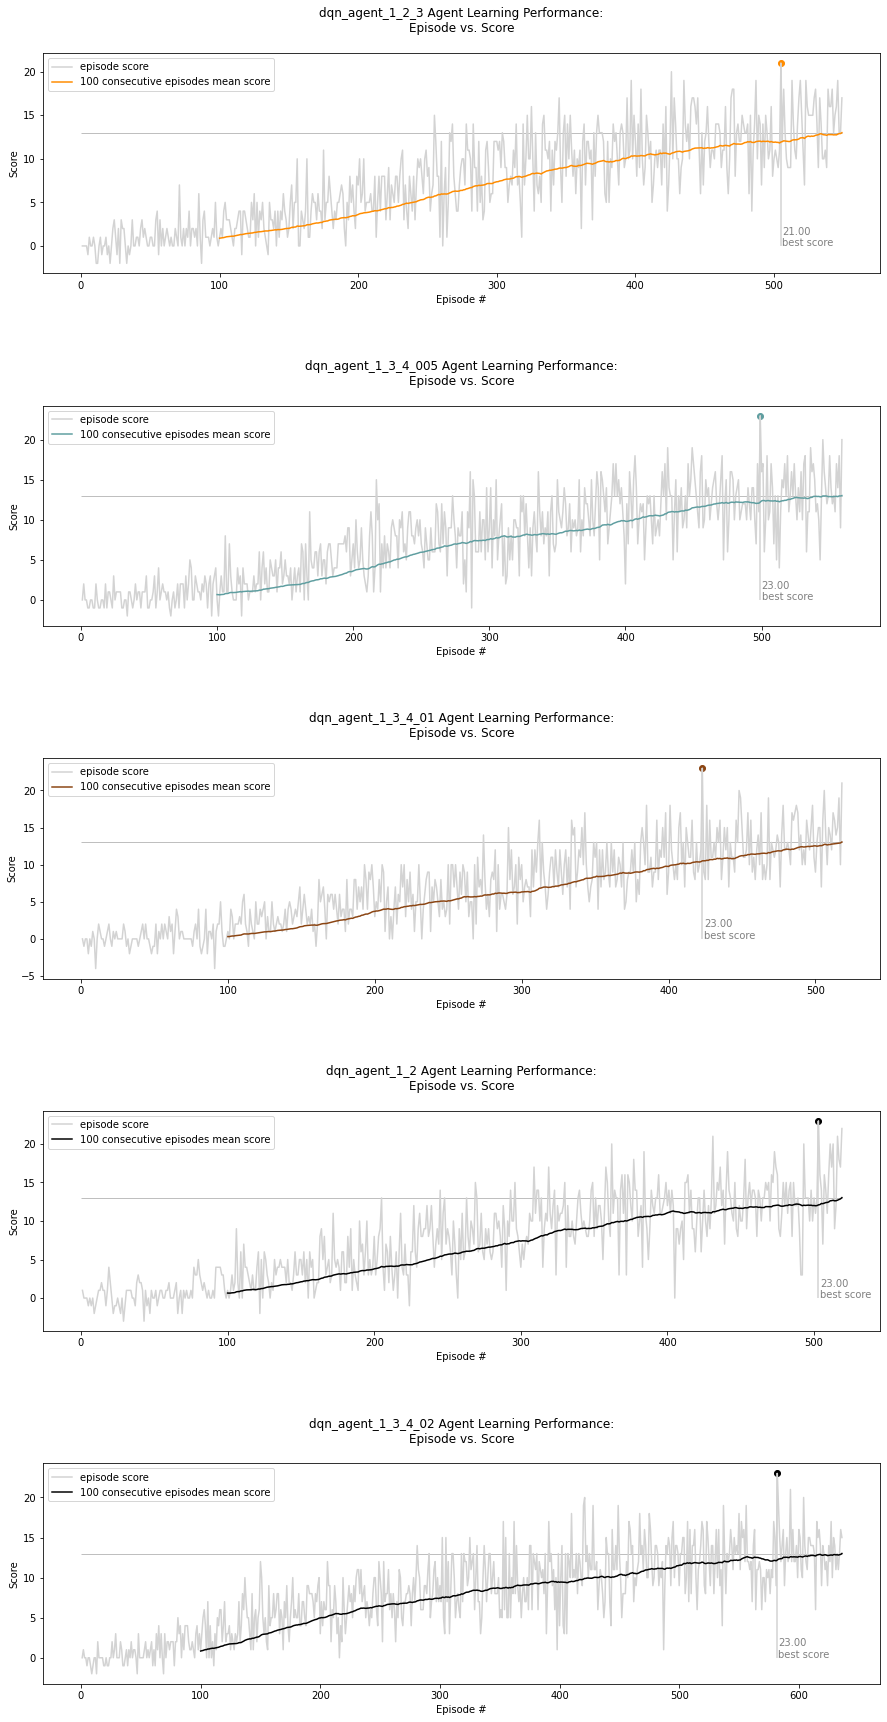

In [17]:
print('Learning Session\n')
plot_agent_learning(agents = agent_learning_speed['agent'].values)

#### Learning Rate

> The learning rate plot shows the agent's potential for improvement at the time that it reaches the goal

We can see that from the three fastest learning agents, the one that implements _Prioritized Experience Replay_ has a higher learning rate at the time the goal is reached.

This metric suggests that this agent may reach a bigger goal faster that the other two 

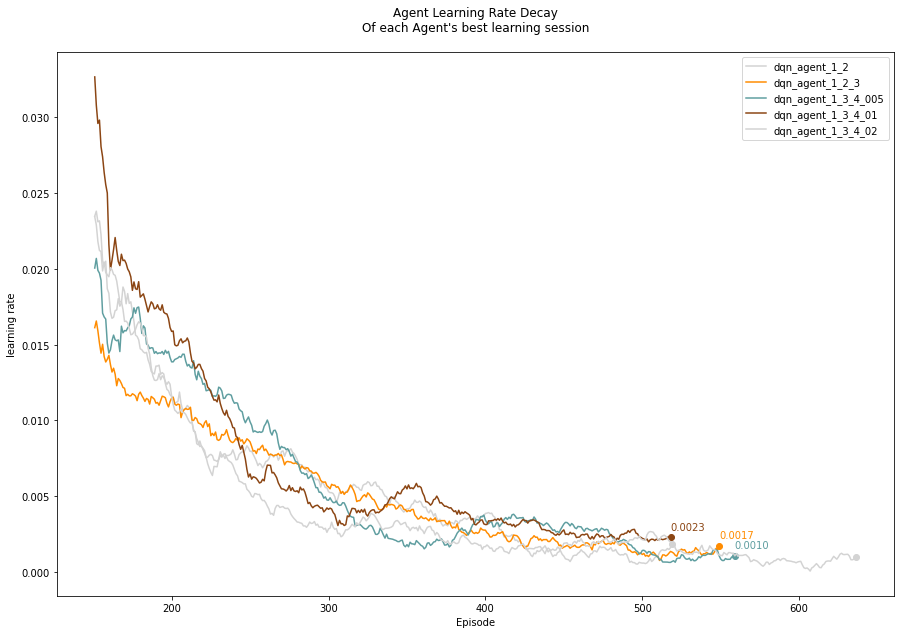

In [18]:
plot_learning_rate(agents)